## Project: Analysing Currency Trends.

***

### 1. Data Collection

***

Importing libraries.

In [1]:
import yfinance as yf
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


I'm getting data with a 60-minute interval covering 2 years, which is the maximum amount limited by Yahoo Finance. If I'm trying to get more data returned, "The requested range must be within the last 730 days".

***

#### Data related to the United States Dollar currency (USD represent by symbol **$**).

Raw data are taken from Yahoo Finance.

In [2]:
# Download 2 years of hourly data for USDGBP and USDEUR currency pairs
usd2y = yf.download(['USDGBP=X','USDEUR=X'], period='2y', interval='60m', group_by='ticker')
# Download 5 years of daily data for USDGBP and USDEUR currency pairs
usd5y = yf.download(['USDGBP=X','USDEUR=X'], period='5y', interval='1d', group_by='ticker')
# Download 5 days of 5 minute data for USDGBP and USDEUR currency pairs
usd5d = yf.download(['USDGBP=X','USDEUR=X'], period='5d', interval='5m', group_by='ticker')


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Saving the data to CSV files.

In [3]:
# Save the data to CSV files
usdToSave = [usd2y, usd5y, usd5d]
filenames = ['usd2y.csv', 'usd5y.csv', 'usd5d.csv']
for i in range(3):
    usdToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')


Data saved to CSV files


#### Data related to the Great British Pound (often referred to simply as the British Pounds) currency (GBP represent by symbol **£**).

Raw data are taken from Yahoo Finance.

In [4]:
# Download 2 years of hourly data for GBPUSD and EURUSD currency pairs
gbp2y = yf.download(['GBPUSD=X', 'GBPEUR=X'], period='2y', interval='60m', group_by='ticker')
# Download 5 years of daily data for GBPUSD and EURUSD currency pairs
gbp5y = yf.download(['GBPUSD=X', 'GBPEUR=X'], period='5y', interval='1d', group_by='ticker')
# Download 5 days of 5 minute data for GBPUSD and EURUSD currency pairs
gbp5d = yf.download(['GBPUSD=X', 'GBPEUR=X'], period='5d', interval='5m', group_by='ticker')


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Saving the data to CSV files.

In [5]:
# Save the data to CSV files
gbpToSave = [gbp2y, gbp5y, gbp5d]
filenames = ['gbp2y.csv', 'gbp5y.csv', 'gbp5d.csv']
for i in range(3):
    gbpToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')

Data saved to CSV files


#### Data related to official currency of the Eurozone knows as Euro currency (EUR: represent by **€**). 

Raw data are taken from Yahoo Finance.

In [6]:
# Download 2 years of hourly data for EURUSD and EURGBP currency pairs
eur2y = yf.download(['EURUSD=X', 'EURGBP=X'], period='2y', interval='60m', group_by='ticker')
# Download 5 years of daily data for EURUSD and EURGBP currency pairs
eur5y = yf.download(['EURUSD=X', 'EURGBP=X'], period='5y', interval='1d', group_by='ticker')
# Download 5 days of 5 minute data for EURUSD and EURGBP currency pairs
eur5d = yf.download(['EURUSD=X', 'EURGBP=X'], period='5d', interval='5m', group_by='ticker')


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Saving the data to CSV files.

In [7]:
# Save the data to CSV files
eurToSave = [eur2y, eur5y, eur5d]
filenames = ['eur2y.csv', 'eur5y.csv', 'eur5d.csv']
for i in range(3):
    eurToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')


Data saved to CSV files


#### Data related to the Bitcoin cryptocurrency (BTC represented by symbol **₿**)

Raw data are taken from Yahoo Finance.

In [8]:
# Download 2 years of hourly data for BTCUSD, BTCGBP and BTCEUR currency pairs
btc2y = yf.download(['BTC-USD', 'BTC-GBP', 'BTC-EUR'], period='2y', interval='60m', group_by='ticker')
# Download 5 years of daily data for BTCUSD, BTCGBP and BTCEUR currency pairs
btc5y = yf.download(['BTC-USD', 'BTC-GBP', 'BTC-EUR'], period='5y', interval='1d', group_by='ticker')
# Download 5 days of 5 minute data for BTCUSD, BTCGBP and BTCEUR currency pairs
btc5d = yf.download(['BTC-USD', 'BTC-GBP', 'BTC-EUR'], period='5d', interval='5m', group_by='ticker')


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


Saving the data to CSV files.

In [9]:
# Save the data to CSV files
btcToSave = [btc2y, btc5y, btc5d]
filenames = ['btc2y.csv', 'btc5y.csv', 'btc5d.csv']
for i in range(3):
    btcToSave[i].to_csv(f'data/csv/{filenames[i]}')
print('Data saved to CSV files')


Data saved to CSV files


***

#### Preparing data to transfer to the Database.

Database Setup:

I will create an SQLite database named currency.db and set up individual tables for each currency pair and corresponding datasets. I will then insert the data from the CSV files into the tables. To ensure compatibility with the database structure, I need to flatten the multi-index columns in the data frames before inserting them into the database.

Reason for Downloading Separately:

When I attempted to download all the datasets at once, I noticed that some data was consistently missing or lost, even though the requested datasets were the same. This issue likely stemmed from limited access to Yahoo Finance's API, which can result in data loss when simultaneously querying large amounts of data.
By downloading the data separately, I can mitigate this problem and ensure I collect the better quality dataset for each currency pair without risking data corruption or loss due to API limitations.

Visual inspection of the data shows that the data is downloaded correctly. I noticed that the date format is different in 5 years of daily data than in 2 years of hourly data and 5 days of 5-minute data. I converted the date format to the same like in 2 years of hourly data and 5 days of 5-minute data.

Flattening the dataframes.

In [10]:
# List of DataFrames for 2 years, 5 years, and 5 days data
all2y = [usd2y, gbp2y, eur2y, btc2y]
all5y = [usd5y, gbp5y, eur5y, btc5y]
all5d = [usd5d, gbp5d, eur5d, btc5d]

# Reset index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.reset_index(inplace=True)  # Resets the index for each DataFrame

# Function to flatten multi-index columns into single-level columns
def flatten_columns(df):
    # Rename 'Date' to 'Datetime' for all DataFrames in all5y
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'Datetime'}, inplace=True)
    
    # Flatten multi-index columns to single level
    df.columns = ['Datetime' if isinstance(col, tuple) and col[0] == 'Datetime' 
                  else '_'.join(col).strip() for col in df.columns]

# Apply flatten_columns function to each DataFrame in all lists
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        flatten_columns(df)
        
# Setting index for all DataFrames
for df_list in [all2y, all5y, all5d]:
    for df in df_list:
        df.set_index('Datetime', inplace=True)



Transfer CSVfiles to the SQLite Database.

In [11]:

# Connect to SQLite database (creates file if it doesn't exist)
conn = sqlite3.connect('data/db/currencies.db')

# List of DataFrames and their corresponding table names
dataframes = [(usd2y, 'usd2y'), (usd5y, 'usd5y'), (usd5d, 'usd5d'), 
              (gbp2y, 'gbp2y'), (gbp5y, 'gbp5y'), (gbp5d, 'gbp5d'), 
              (eur2y, 'eur2y'), (eur5y, 'eur5y'), (eur5d, 'eur5d'), 
              (btc2y, 'btc2y'), (btc5y, 'btc5y'), (btc5d, 'btc5d')]
# Loop to write each DataFrame to the SQLite database
for df, table_name in dataframes:
    df.to_sql(table_name, conn, if_exists='replace', index=True)
    
# Close the connection to SQLite
conn.close()

print("Data successfully written to SQLite database!")


Data successfully written to SQLite database!


Checking what tables contain the Database.

In [12]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')
cursor = conn.cursor()

# Query to list tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the tables
print("Tables in the database:")
for table in tables:
    print(table[0])

# Close the connection
conn.close()

Tables in the database:
usd2y
usd5y
usd5d
gbp2y
gbp5y
gbp5d
eur2y
eur5y
eur5d
btc2y
btc5y
btc5d


Testing  query to the Database.

In [13]:
# Connect to the SQLite database
conn = sqlite3.connect('data/db/currencies.db')

# Read data from the table into a pandas DataFrame
query = "SELECT * FROM gbp5y LIMIT 5;"  # Adjust for your table name
df = pd.read_sql(query, conn)
df.set_index('Datetime', inplace=True)

# Display the DataFrame

df

,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,GBPEUR=X_Adj Close,GBPEUR=X_Volume,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close,GBPUSD=X_Adj Close,GBPUSD=X_Volume
Datetime,,,,,,,,,,,,
2019-12-17 00:00:00,1.19140,1.19311,1.17507,1.19156,1.19156,0,1.327175,1.330495,1.310410,1.327246,1.327246,0
2019-12-18 00:00:00,1.17650,1.17847,1.17406,1.17659,1.17659,0,1.312215,1.312560,1.306233,1.312215,1.312215,0
2019-12-19 00:00:00,1.17699,1.17925,1.16898,1.17670,1.17670,0,1.308472,1.312956,1.299663,1.308729,1.308729,0
2019-12-20 00:00:00,1.17007,1.17938,1.16950,1.17000,1.17000,0,1.301643,1.307839,1.300830,1.301744,1.301744,0
2019-12-23 00:00:00,1.17367,1.17554,1.16416,1.17366,1.17366,0,1.300525,1.303254,1.290706,1.300542,1.300542,0


Understanding collected data is kind of important. We can identify columns called:
* Open: Price at the start of the trading period.
* High: Highest price during the trading period.
* Low: Lowest price during the trading period.
* Close: Price at the end of the trading period.
* Adj Close: Close price adjusted for events like splits or dividends (not relevant in this case).
* Volume: Total amount of the asset traded during the period.

Display the first 3 row are commented out and was use only to check Data Frame and discover column names.

***

### 2. Data Cleaning

I chose to analyse OHLC data (Open, High, Low, Close) because it provides a comprehensive view of price movements, which is essential for identifying market trends and making informed trading decisions.

I will omit other data, such as volume or adjusted close, as they are less relevant for understanding price action and trend analysis. After examining the data, it is clear that the Adj Close column contains the same values as the Close column, and the Volume column is empty.

Formatting Data Frames for easier manipulation 

In [14]:
# Columns to drop (targeting columns that have '_Adj Close' or '_Volume' suffixes)
columnsToDrop = ['_Adj Close', '_Volume']

# List of DataFrames for each asset
dfColumnsDroppedList = [usd2y, gbp2y, eur2y, btc2y, usd5y, gbp5y, eur5y, btc5y, usd5d, gbp5d, eur5d, btc5d]

# Iterate over each DataFrame and drop columns that contain '_Adj Close' or '_Volume'
for df in dfColumnsDroppedList:
    df.drop([col for col in df.columns if any(drop in col for drop in columnsToDrop)], axis=1, inplace=True)

# Verify the result (Optional)
usd2y.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close
Datetime,,,,,,,,
2022-12-19 00:00:00,0.9444,0.9447,0.9431,0.9433,0.82224,0.82268,0.82102,0.82106
2022-12-19 01:00:00,0.9431,0.9434,0.9426,0.9426,0.82111,0.82135,0.81983,0.81987
2022-12-19 02:00:00,0.9424,0.9429,0.9419,0.9424,0.82022,0.82082,0.81959,0.82081


In [15]:
# Merge the DataFrames using 'Datetime' column and add suffixes
mergedFiatCurrencies2y = usd2y.merge(eur2y, how='outer', on='Datetime', suffixes=('_USD', '_EUR')).merge(gbp2y, how='outer', on='Datetime', suffixes=('_EUR', '_GBP'))
mergedFiatCurrencies5d = usd5d.merge(eur5d, how='outer', on='Datetime', suffixes=('_USD', '_EUR')).merge(gbp5d, how='outer', on='Datetime', suffixes=('_EUR', '_GBP'))
mergedFiatCurrencies5y = usd5y.merge(eur5y, how='outer', on='Datetime', suffixes=('_USD', '_EUR')).merge(gbp5y, how='outer', on='Datetime', suffixes=('_EUR', '_GBP'))


#### Fill missing values using forward fill (ffill) method

In [16]:
# List of DataFrames
dataframes = [mergedFiatCurrencies2y, mergedFiatCurrencies5y, mergedFiatCurrencies5d, btc2y, btc5y, btc5d]

# Forward fill missing values for each DataFrame in the list
for df in dataframes:
    df.ffill(inplace=True)


#### Checking Datetime format if it is in expected form: '%Y-%m-%d %H:%M:%S'.

In [17]:
# Check if 'Datetime' is in any level of the MultiIndex
if 'Datetime' in mergedFiatCurrencies2y.index.names:
    # Extract the 'Datetime' level from the MultiIndex
    datetime_column = mergedFiatCurrencies2y.index.get_level_values('Datetime')
    
    # Check if the 'Datetime' index is in datetime64 format
    if pd.api.types.is_datetime64_any_dtype(datetime_column):
        # Display the format of the 'Datetime' index
        datetime_format = datetime_column[0].strftime('%Y-%m-%d %H:%M:%S')  # You can adjust the format as needed
        print(f"The 'Datetime' index is correctly formatted as datetime64.\nExample of the format: {datetime_format}\nThere is no action required.")
    else:
        print("The 'Datetime' index is not in datetime64 format.\nPlease convert it.")


The 'Datetime' index is correctly formatted as datetime64.
Example of the format: 2022-12-19 00:00:00
There is no action required.


#### Normalise Bitcoin exchange rates

Normalisation is a technique used to adjust data to a consistent scale, enabling a more straightforward comparison of how values, such as prices, vary or change relative 
to one another.

I've used different normalisation techniques, such as Base Value Normalisation, Min-Max Normalisation, and z-score normalisation, to show how to perform 
normalisation. Because I will compare Bitcoin to other currencies, all compared must be normalised using the same method.


##### Indexing to a Base Value or Base Value Normalisation. 

This method expresses all data points as a percentage relative to the first value in the dataset.

In [18]:
# Normalising the data

# List of DataFrames to normalise
btcDataFrames = [btc2y, btc5y, btc5d]

# Normalise each DataFrame and store them in a list
normalisedBasedValueBtcFrames = [df.div(df.iloc[0]).mul(100) for df in btcDataFrames]

# Assign normalised DataFrames to distinct variables
normalisedBasedValuebtc2y, normalisedBasedValuebtc5y, normalisedBasedvaluebtc5d = \
normalisedBasedValueBtcFrames[0], normalisedBasedValueBtcFrames[1], normalisedBasedValueBtcFrames[2]
normalisedBasedvaluebtc5d.head(3)

,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-GBP_Open,BTC-GBP_High,BTC-GBP_Low,BTC-GBP_Close
Datetime,,,,,,,,,,,,
2024-12-13 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-12-13 00:05:00+00:00,100.068158,100.197764,100.094998,100.214128,100.043737,100.191980,100.083249,100.222209,100.065423,100.205071,100.101137,100.218146
2024-12-13 00:10:00+00:00,100.162198,100.161256,99.989296,99.969712,100.154952,100.154952,100.028846,100.019523,100.163083,100.163083,99.997623,99.972333


In [19]:
# List of DataFrames to normalise
fiatDataFrames = [mergedFiatCurrencies2y, mergedFiatCurrencies5y, mergedFiatCurrencies5d]

# Normalise each DataFrame and store them in a list
normalisedBasedValueFiatFrames = [df.div(df.iloc[0]).mul(100) for df in fiatDataFrames]

# Assign normalised DataFrames to distinct variables
normalisedBasedValueFiat2y, normalisedBasedValueFiat5y, normalisedBasedValueFiat5d = \
normalisedBasedValueFiatFrames[0], normalisedBasedValueFiatFrames[1], normalisedBasedValueFiatFrames[2]
normalisedBasedValueFiat5d.head(3)

,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURUSD=X_Open,EURUSD=X_High,...,EURGBP=X_Low,EURGBP=X_Close,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-11 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-12-11 00:05:00+00:00,100.010536,100.010527,100.010536,100.010527,100.039618,100.012769,100.037059,100.012769,99.989464,99.989464,...,100.019415,100.007275,99.960394,99.962950,99.987234,99.987234,99.971980,99.976097,100.000000,100.000000
2024-12-11 00:10:00+00:00,100.031601,100.010527,100.021072,100.010527,100.054952,100.020437,100.051120,100.014048,99.968404,99.978929,...,100.020630,99.998785,99.945077,99.948902,99.979573,99.985956,99.969505,99.971155,99.991753,99.997524


This approach is widely used to standardise time-series data, making comparing trends across different datasets or variables easier. It is particularly useful in financial and economic contexts, such as analysing stock prices, cryptocurrency values, or economic indicators. 

Read more on the [Medium Website](https://medium.com/coinmonks/cryptocurrency-analysis-with-python-understanding-normalization-returns-rewards-and-risk-7e4d530c917).

##### Min-max Normalisation

Min-max normalisation is a widely used method to scale data. In this approach, the smallest value of a feature is mapped to 0, the largest value is mapped to 1, and all other values are scaled proportionally to lie within the range of 0 and 1.

In [20]:
# List of DataFrames
btcDataframes = [btc2y, btc5y, btc5d]

# Initialize the Min-Max Scaler
minMaxScaler = preprocessing.MinMaxScaler()

# Apply Min-Max scaling to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        minMaxScaler.fit_transform(df), 
        columns=df.columns, 
        index=df.index
    )
    for df in btcDataframes
]

# Unpack the normalized DataFrames
normalisedMinMaxBtc2y, normalisedMinMaxBtc5y, normalisedMinMaxBtc5d = normalisedDfs

# Display the first 3 rows of the normalised DataFrame for 5 years
normalisedMinMaxBtc5y.head(3)


,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-GBP_Open,BTC-GBP_High,BTC-GBP_Low,BTC-GBP_Close
Datetime,,,,,,,,,,,,
2019-12-17,0.018072,0.014726,0.023052,0.015714,0.019087,0.016206,0.024406,0.016566,0.015474,0.011794,0.021766,0.013931
2019-12-18,0.015347,0.018382,0.022825,0.021869,0.016280,0.019789,0.023935,0.022879,0.013492,0.015828,0.021611,0.020239
2019-12-19,0.021429,0.018580,0.027378,0.021128,0.022514,0.020004,0.028866,0.022145,0.019722,0.016025,0.026257,0.019883


In [21]:
# List of DataFrames
fiatDataFrames = [mergedFiatCurrencies2y, mergedFiatCurrencies5y, mergedFiatCurrencies5d]

# Initialize the Min-Max Scaler
minMaxScaler = preprocessing.MinMaxScaler()

# Apply Min-Max scaling to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        minMaxScaler.fit_transform(df), 
        columns=df.columns, 
        index=df.index
    )
    for df in fiatDataFrames
]

# Unpack the normalized DataFrames
normalisedMinMaxMergeFiat2y, normalisedMinMaxMergeFiat5y, normalisedMinMaxMergeFiat5d = normalisedDfs

# Display the first 3 rows of the normalised DataFrame for 5 years
normalisedMinMaxMergeFiat5y.head(3)


,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURGBP=X_Open,EURGBP=X_High,...,EURUSD=X_Low,EURUSD=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-17,0.377353,0.357082,0.380091,0.377988,0.220817,0.222084,0.224922,0.220429,0.135355,0.207740,...,0.583378,0.561322,0.847441,0.807735,0.769338,0.848891,0.726837,0.723815,0.719607,0.727278
2019-12-18,0.372344,0.363863,0.387844,0.372983,0.258288,0.231558,0.271391,0.258069,0.225228,0.213291,...,0.576212,0.566571,0.750794,0.697999,0.762991,0.752053,0.684084,0.671248,0.708578,0.684325
2019-12-19,0.384738,0.364378,0.391097,0.385322,0.267798,0.246583,0.270350,0.266923,0.222380,0.243302,...,0.575668,0.553655,0.753973,0.703845,0.731072,0.752765,0.673386,0.672410,0.691228,0.674362


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Min-max normalization ensures that all features are scaled to the same range, typically between 0 and 1. Still, it is ineffective at managing outliers, as they can significantly skew the results. 

##### Z-score normalization


Z-score normalisation is a method that helps to avoid problems with outliers. If a value is the same as the mean of a feature, it is normalised to 0. If the value is below the mean, it becomes a negative number; if it is above the mean, it turns positive. 
The size of these negative and positive values is determined by how spread out the original data is based on its standard deviation. In simpler terms, if the original data points vary widely, the normalised values will be smaller. Conversely, the normalised values will be larger if the original data has less variation.


In [22]:
# List of DataFrames
btcDataframes = [btc2y, btc5y, btc5d]

# Initialize the Z-score scaler
scalerZscore = StandardScaler()

# Apply Z-score normalization to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        scalerZscore.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    for df in btcDataframes
]

# Unpack the normalized DataFrames
normalisedZscoreBtc2y, normalisedZscoreBtc5y, normalisedZscoreBtc5d = normalisedDfs

# Display the first 3 rows of the normalized DataFrame for 5 years
normalisedZscoreBtc2y.head(3)


,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-EUR_Open,BTC-EUR_High,BTC-EUR_Low,BTC-EUR_Close,BTC-GBP_Open,BTC-GBP_High,BTC-GBP_Low,BTC-GBP_Close
Datetime,,,,,,,,,,,,
2022-12-17 00:00:00,-1.399029,-1.396283,-1.398437,-1.395360,-1.367049,-1.364428,-1.366405,-1.363234,-1.394866,-1.391987,-1.394216,-1.390714
2022-12-17 01:00:00,-1.395472,-1.395986,-1.396376,-1.396666,-1.363510,-1.364128,-1.364448,-1.364697,-1.390993,-1.391670,-1.392016,-1.392260
2022-12-17 02:00:00,-1.396882,-1.398032,-1.399523,-1.397285,-1.364828,-1.365993,-1.367625,-1.365497,-1.392387,-1.393641,-1.395374,-1.393106


***

In [23]:
# List of DataFrames
fiatDataFrames = [mergedFiatCurrencies2y, mergedFiatCurrencies5y, mergedFiatCurrencies5d]
btcDataframes = [btc2y, btc5y, btc5d]

# Initialize the Z-score scaler
scalerZscore = StandardScaler()

# Apply Z-score normalization to each DataFrame and store them
normalisedDfs = [
    pd.DataFrame(
        scalerZscore.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    for df in fiatDataFrames
]

# Unpack the normalized DataFrames
normalisedZscoreFiat2y, normalisedZscoreFiat5y, normalisedZscoreFiat5d = normalisedDfs

# Display the first 3 rows of the normalized DataFrame for 5 years
normalisedZscoreFiat5y.head(3)



,USDEUR=X_Open,USDEUR=X_High,USDEUR=X_Low,USDEUR=X_Close,USDGBP=X_Open,USDGBP=X_High,USDGBP=X_Low,USDGBP=X_Close,EURGBP=X_Open,EURGBP=X_High,...,EURUSD=X_Low,EURUSD=X_Close,GBPEUR=X_Open,GBPEUR=X_High,GBPEUR=X_Low,GBPEUR=X_Close,GBPUSD=X_Open,GBPUSD=X_High,GBPUSD=X_Low,GBPUSD=X_Close
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-17,-0.130543,-0.179916,-0.134912,-0.129911,-0.676317,-0.501336,-0.667746,-0.677133,-1.158296,-0.697427,...,0.128371,0.078180,1.180121,1.149977,0.701074,1.186123,0.656204,0.645528,0.469158,0.657067
2019-12-18,-0.155221,-0.146779,-0.097348,-0.154583,-0.462745,-0.442045,-0.406500,-0.462562,-0.654485,-0.665882,...,0.094809,0.103083,0.650856,0.619597,0.665875,0.654421,0.427298,0.367538,0.406014,0.427089
2019-12-19,-0.094164,-0.144262,-0.081590,-0.093755,-0.408544,-0.348004,-0.412351,-0.412088,-0.670448,-0.495354,...,0.092264,0.041800,0.668264,0.647854,0.488846,0.658329,0.370025,0.373682,0.306684,0.373746


According to the [Codeacadamy website ](https://www.codecademy.com/article/normalization#heading-review:~:text=Min%2Dmax%20normalization%3A%20Guarantees%20all%20features%20will%20have%20the%20exact%20same%20scale%20but%20does%20not%20handle%20outliers%20well.) Z-score normalisation handles outliers but does not scale data to a consistent range.

***

### 3. Exploratory Data Analysis (EDA)

Plotting line charts to visualize historical trends.

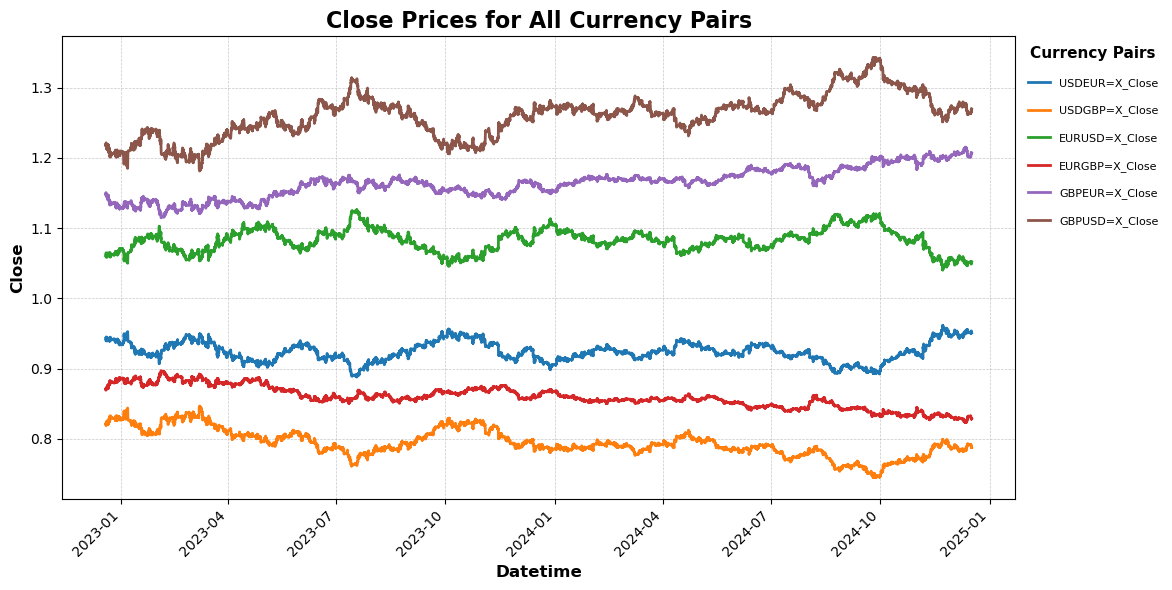

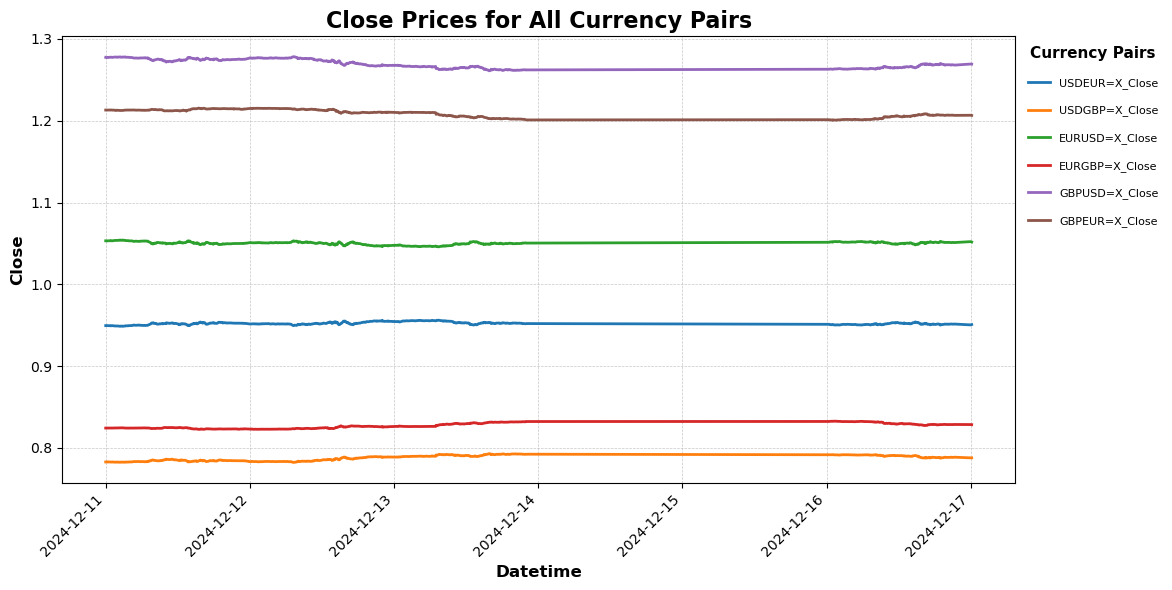

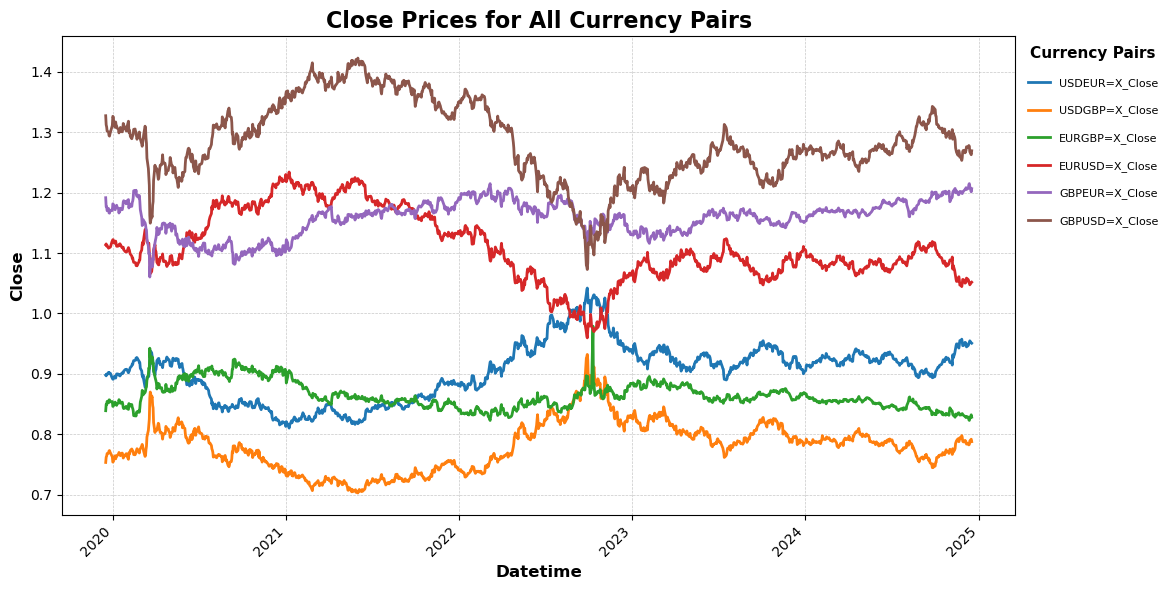

In [32]:
import matplotlib.pyplot as plt

# List of datasets to plot
datasets = [mergedFiatCurrencies2y, mergedFiatCurrencies5d, mergedFiatCurrencies5y]

# Loop through each dataset and plot Close prices
for df in datasets:
    plt.figure(figsize=(12, 6))
    for column in df.columns:
        if 'Close' in column:
            plt.plot(df.index, df[column], label=column, linewidth=2)
    plt.xlabel('Datetime', fontsize=12, fontweight='bold')
    plt.ylabel('Close', fontsize=12, fontweight='bold')
    plt.title('Close Prices for All Currency Pairs', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    
    from matplotlib import font_manager

    plt.legend(loc='upper left', bbox_to_anchor=(1.003, 1), title='Currency Pairs',     
           frameon=False, fancybox=True, shadow=True, fontsize=8, 
           title_fontproperties=font_manager.FontProperties(weight='bold', size=11),labelspacing=1.5)  # Bold and set font size
 
    plt.subplots_adjust(right=0.85)
    plt.show()
    
